In [1]:
import numpy as np
from astropy.table import Table, Column, join
from astropy.coordinates import SkyCoord
from astropy.table import Column
from numpy import *
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.wcs import WCS
from astropy.io import fits
from matplotlib.colors import LogNorm
from astropy.utils.data import download_file
import warnings

catalog_path='/Users/EvanB.LAPTOP-8CHCIOMA/Downloads/'

#A100-NSA Catalog
myTab=Table.read(catalog_path+'a100-nsa-for-adap.fits')

In [6]:

def Local_Density(cuttab):
    ra = np.array(cuttab['RA']) # Right ascension of each galaxy
    dec = np.array(cuttab['DEC']) # Declination of each galaxy

    points = []
    for i in range(len(dec)):
        points.append((ra[i],dec[i])) # Array of tuples of ra and dec (each galaxy now represented by a point)

    def distance(ra1, dec1, ra2, dec2):
        return ((ra1 - ra2) ** 2 + (dec1 - dec2) ** 2) ** ( 1 / 2) # Distance between two points    

    def Five_Nearest(points, target, K):
        pts = []
        n = len(points)
        d = []
 
        for i in range(n):
            d.append({
                "first": distance(points[i][0], points[i][1], target[0], target[1]), # Finds distance between target point and another point
                "second": i # Stores new point that had its distance relative to the target found
            })
     
        d = sorted(d, key=lambda l:l["first"]) # Sorts d from smallest to largest distance for each target point
 
        for i in range(K): # Loops through for however many times are specified by K (I will use K=6)
            pt = []
            pt.append(points[d[i]["second"]][0]) # First element of a tuple in an array of nearest points sorted by distance
            pt.append(points[d[i]["second"]][1]) # Second element of a tuple in an array of nearest points sorted by distance
            pts.append(pt) # Stores all individual pt values as tuples
 
        return pts # Returns the six nearest galaxies to a target galaxy (the first of which is the original target galaxy)


    # Find five nearest galaxies to each galaxy

    five_nn = [] # Store nearest neighbors
    K = 6 # Number of times to calaculate nearest neighbors

    for i in range(len(points)):
        target = points[i] # Switches target point
        for pt in Five_Nearest(points, target, K): # Calculates five nearest points for each points in points and stores them along with their targets
            five_nn.append((pt[0], pt[1])) # Includes six points for each target, the first of which in each set is the target itself
        

    # Separating target points from fifth nearest points

    target_fnn = points #five_nn[0::6] # list of original target galaxies
    fifth_nearest_neighbors = five_nn[5::6] # fifth nearest point of each target


    # Finding angular distance

    dist_fifthnn = []

    # Calculates distance between each galaxy and its fifth nearest meighbor

    for i in range(len(fifth_nearest_neighbors)):
        target0 = target_fnn[i] # Changes target on each loop through
        dist_fifthnn.append(distance(fifth_nearest_neighbors[i][0], fifth_nearest_neighbors[i][1], target0[0], target0[1])) # Produces distance array
 
    angle = np.array(dist_fifthnn)


    # Redshifts of fifth nearest neighbors

    # This compares each point in fifth nearest neighbors to each point in points and stores their respective z values
    z_fnn = []
    for i in range(len(fifth_nearest_neighbors)):
        for j in range(len(points)): 
            if fifth_nearest_neighbors[i][0] == points[j][0]:
                z_fnn.append(cuttab['ZDIST'][j]) 
            
            
    # Converting angular distances to kpc

    # Array of redshifts for each fifth nearest neighbor
    z = np.array(z_fnn)

    # Convert angles in degrees to radians
    radians = (np.pi/180)*(angle)

    # Finding distance, in m, between the Sun and the galaxies
    H0 = 2.3*10**(-18) #/s
    c = 3*10**8 #m/s

    v = z*c 
    d = v/H0 #m

    # Using small angle approximation to convert to kpc
    r_5 = (d*radians)*(3*10**(-19)) #kpc


    # Find fifth nearest neighbor density
    sigma_5 = 1/(r_5**2)
    
    return sigma_5

In [14]:
# R-band Magnitude Limit
Mrmax = -18.2
Mr = myTab['ABSMAG'][:,4] # R-band magnitude from catalog
Mrflag = Mr < Mrmax # Cuts r-band magnitudes greater than the max r-band magnitude limit

# Velocity input
vinput = int(input()) # Asks for a velocity to create a new cut based off of
v = myTab['Vhelio'] # Recessional velocity from catalog
vflag = (v > -1*vinput) & (v < vinput) # Applies a cut (+/- the input velocity) to the data set 

# Redshift cut
zdist = myTab['ZDIST']
zflag = (zdist > 0.002) & (zdist < 0.012)


cut = Mrflag & vflag & zflag # Combines both cuts

cuttab = myTab[cut]

 1500


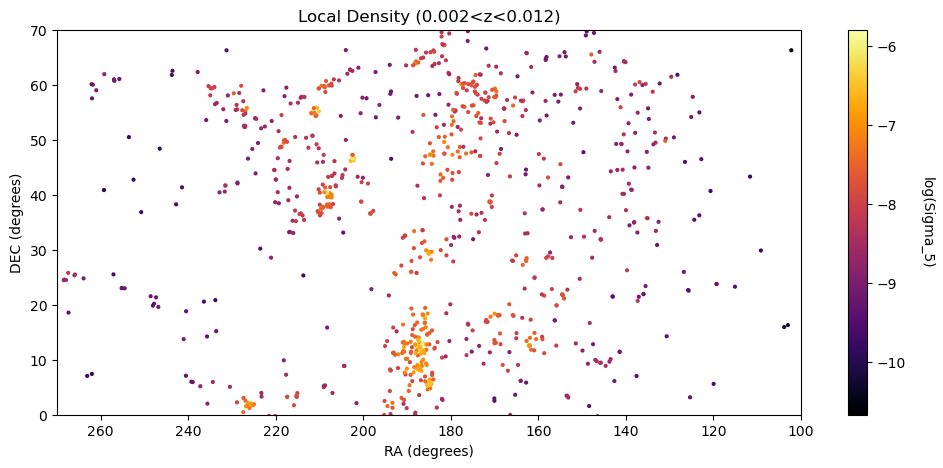

In [16]:
# Plot with range of 0.002<z<0.012
ra = cuttab['RA']
dec = cuttab['DEC']
ccode = np.log10(Local_Density(cuttab))

#Plot RA vs DEC and color it by recessional velocity
plt.figure(figsize=(12,5))
plt.scatter(ra,dec,c=ccode,cmap='inferno',s=4) # ,alpha=0.8
plt.xlim(reversed(plt.xlim()))
plt.title('Local Density (0.002<z<0.012)')
plt.xlabel('RA (degrees)')
plt.ylabel('DEC (degrees)')
plt.xlim(270,100)
plt.ylim(0,70)
cbar = plt.colorbar()
cbar.set_label('log(Sigma_5)',rotation=270,labelpad=20)

In [28]:
# Redshift cut
zdist2 = myTab['ZDIST']
zflag2 = (zdist2 > 0.012) & (zdist2 < 0.022)


cut2 = Mrflag & vflag & zflag2 # Combines both cuts

cuttab2 = myTab[cut2]

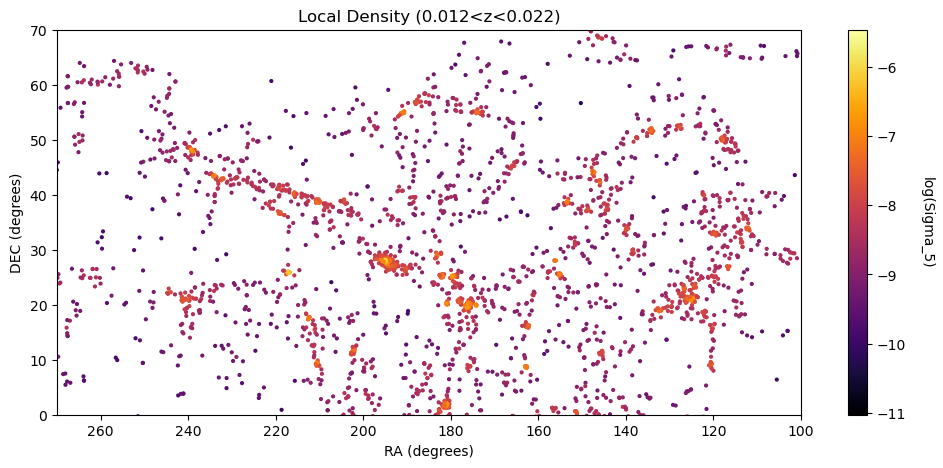

In [29]:
# Plot with range of 0.012<z<0.022
ra = cuttab2['RA']
dec = cuttab2['DEC']
ccode = np.log10(Local_Density(cuttab2))

#Plot RA vs DEC and color it by recessional velocity
plt.figure(figsize=(12,5))
plt.scatter(ra,dec,c=ccode,cmap='inferno',s=4) # ,alpha=0.8
plt.xlim(reversed(plt.xlim()))
plt.title('Local Density (0.012<z<0.022)')
plt.xlabel('RA (degrees)')
plt.ylabel('DEC (degrees)')
plt.xlim(270,100)
plt.ylim(0,70)
cbar = plt.colorbar()
cbar.set_label('log(Sigma_5)',rotation=270,labelpad=20)

In [30]:
# Redshift cut
zdist3 = myTab['ZDIST']
zflag3 = (zdist3 > 0.022) & (zdist3 < 0.025)


cut3 = Mrflag & vflag & zflag3 # Combines both cuts

cuttab3 = myTab[cut3]

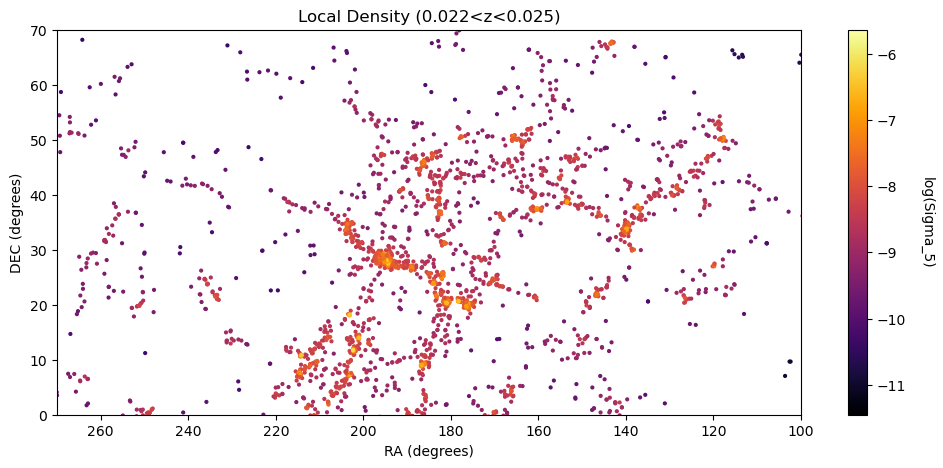

In [32]:
# Plot with range of 0.022<z<0.025
ra = cuttab3['RA']
dec = cuttab3['DEC']
ccode = np.log10(Local_Density(cuttab3))

#Plot RA vs DEC and color it by recessional velocity
plt.figure(figsize=(12,5))
plt.scatter(ra,dec,c=ccode,cmap='inferno',s=4) # ,alpha=0.8
plt.xlim(reversed(plt.xlim()))
plt.title('Local Density (0.022<z<0.025)')
plt.xlabel('RA (degrees)')
plt.ylabel('DEC (degrees)')
plt.xlim(270,100)
plt.ylim(0,70)
cbar = plt.colorbar()
cbar.set_label('log(Sigma_5)',rotation=270,labelpad=20)